# Model Development and Evaluation

**Joeri Hermans** (Technical Student, IT-DB-SAS, CERN)             
*Departement of Knowledge Engineering*         
*Maastricht University, The Netherlands*

This notebook is dedicated to the development and evaluation of a Keras model based on a large [preprocessed dataset](https://github.com/JoeriHermans/dist-keras/blob/master/examples/data_preprocessing.ipynb).

In [19]:
%matplotlib inline  

import numpy as np

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

from pyspark import SparkContext
from pyspark import SparkConf

from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from distkeras.transformers import LabelIndexTransformer
from distkeras.predictors import ModelPredictor
from distkeras.trainers import SingleTrainer
from distkeras.trainers import AEASGD
from distkeras.trainers import DOWNPOUR

## Spark Configuration and Preparation

Edit the variables in the cell below. If you are running Spark in local mode, please set the `local` flag to true and adjust the resources you wish to use on your local machine. The same goes for the case when you are running Spark 2.0 and higher.

In [2]:
# Modify these variables according to your needs.
application_name = "Distributed Deep Learning: Analysis"
using_spark_2 = False
local = False
if local:
    # Tell master to use local resources.
    master = "local[*]"
    num_cores = 3
    num_executors = 1
else:
    # Tell master to use YARN.
    master = "yarn-client"
    num_executors = 8
    num_cores = 2

In [3]:
# This variable is derived from the number of cores and executors, and will be used to assign the number of model trainers.
num_workers = num_executors * num_cores

print("Number of desired executors: " + `num_executors`)
print("Number of desired cores / executor: " + `num_cores`)
print("Total number of workers: " + `num_workers`)

Number of desired executors: 8
Number of desired cores / executor: 2
Total number of workers: 16


In [4]:
conf = SparkConf()
conf.set("spark.app.name", application_name)
conf.set("spark.master", master)
conf.set("spark.executor.cores", `num_cores`)
conf.set("spark.executor.instances", `num_executors`)
conf.set("spark.executor.memory","2g")
conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer");

# Check if the user is running Spark 2.0 +
if using_spark_2:
    sc = SparkSession.builder.config(conf=conf) \
            .appName(application_name) \
            .getOrCreate()
else:
    # Create the Spark context.
    sc = SparkContext(conf=conf)
    # Add the missing imports
    from pyspark import SQLContext
    sqlContext = SQLContext(sc)

## Data Preparation

After the Spark Context (or Spark Session if you are using Spark 2.0) has been set up, we can start reading the preprocessed dataset from storage.

In [5]:
# Check if we are using Spark 2.0
if using_spark_2:
    reader = sc
else:
    reader = sqlContext
# Read the dataset.
raw_dataset = reader.read.parquet("data/processed.parquet")

In [6]:
# Check the schema.
raw_dataset.printSchema()

root
 |-- features_normalized: vector (nullable = true)
 |-- label_index: double (nullable = true)
 |-- label: vector (nullable = true)



After reading the dataset from storage, we will extract several metrics such as `nb_features`, which basically is the number of input neurons, and `nb_classes`, which is the number of classes (signal and background).

In [7]:
nb_features = len(raw_dataset.select("features_normalized").take(1)[0]["features_normalized"])
nb_classes = len(raw_dataset.select("label").take(1)[0]["label"])

print("Number of features: " + str(nb_features))
print("Number of classes: " + str(nb_classes))

Number of features: 30
Number of classes: 2


Finally, we split up the dataset for training and testing purposes, and fetch some additional statistics on the number of training and testing instances.

In [8]:
# Finally, we create a trainingset and a testset.
(training_set, test_set) = raw_dataset.randomSplit([0.7, 0.3])
training_set.cache()
test_set.cache()

DataFrame[features_normalized: vector, label_index: double, label: vector]

In [9]:
# Distribute the training and test set to the workers.
test_set = test_set.repartition(num_workers)
training_set = training_set.repartition(num_workers)

num_test_set = test_set.count()
num_training_set = training_set.count()

print("Number of testset instances: " + str(num_test_set))
print("Number of trainingset instances: " + str(num_training_set))
print("Total number of instances: " + str(num_test_set + num_training_set))

Number of testset instances: 6377863
Number of trainingset instances: 14872137
Total number of instances: 21250000


## Model construction

In [10]:
model = Sequential()
model.add(Dense(500, input_shape=(nb_features,)))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dropout(0.6))
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [11]:
# Summarize the model.
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 500)           15500       dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 500)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 500)           0           activation_1[0][0]               
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 500)           250500      dropout_1[0][0]                  
___________________________________________________________________________________________

In [12]:
optimizer = 'adagrad'
loss = 'categorical_crossentropy'

## Model evaluation

In [13]:
def evaluate(model):
    global test_set

    metric_name = "f1"
    evaluator = MulticlassClassificationEvaluator(metricName=metric_name, predictionCol="prediction_index", labelCol="label_index")
    # Clear the prediction column from the testset.
    test_set = test_set.select("features_normalized", "label", "label_index")
    # Apply a prediction from a trained model.
    predictor = ModelPredictor(keras_model=trained_model, features_col="features_normalized")
    test_set = predictor.predict(test_set)
    # Transform the prediction vector to an indexed label.
    index_transformer = LabelIndexTransformer(output_dim=nb_classes)
    test_set = index_transformer.transform(test_set)
    # Store the F1 score of the SingleTrainer.
    score = evaluator.evaluate(test_set)
    
    return score

In [14]:
results = {}
time_spent = {}

## Model training and evaluation

In the next sections we train and evaluate the models trained by different (distributed) optimizers.

### Single Trainer

In [15]:
trainer = SingleTrainer(keras_model=model, loss=loss, worker_optimizer=optimizer, 
                        features_col="features_normalized", num_epoch=1, batch_size=64)
trained_model = trainer.train(training_set)

In [16]:
# Fetch the training time.
dt = trainer.get_training_time()
print("Time spent (SingleTrainer): " + `dt` + " seconds.")

# Evaluate the model.
score = evaluate(trained_model)
print("F1 (SingleTrainer): " + `score`)

# Store the training metrics.
results['single'] = score
time_spent['single'] = dt

Time spent (SingleTrainer): 5927.329083919525 seconds.
F1 (SingleTrainer): 0.839630118149035


### Asynchronous EASGD

In [17]:
trainer = AEASGD(keras_model=model, worker_optimizer=optimizer, loss=loss, num_workers=num_workers, batch_size=64,
                 features_col="features_normalized", num_epoch=1, communication_window=32, 
                 rho=5.0, learning_rate=0.1)
trainer.set_parallelism_factor(1)
trained_model = trainer.train(training_set)

In [18]:
# Fetch the training time.
dt = trainer.get_training_time()
print("Time spent (AEASGD): " + `dt` + " seconds.")

# Evaluate the model.
score = evaluate(trained_model)
print("F1 (AEASGD): " + `score`)

# Store the training metrics.
results['aeasgd'] = score
time_spent['aeasgd'] = dt

Time spent (AEASGD): 903.8733949661255 seconds.
F1 (AEASGD): 0.8326362659335457


### DOWNPOUR

In [15]:
trainer = DOWNPOUR(keras_model=model, worker_optimizer=optimizer, loss=loss, num_workers=num_workers,
                   batch_size=64, communication_window=5, learning_rate=0.1, num_epoch=1,
                   features_col="features_normalized")
trainer.set_parallelism_factor(1)
trained_model = trainer.train(training_set)

In [16]:
# Fetch the training time.
dt = trainer.get_training_time()
print("Time spent (DOWNPOUR): " + `dt` + " seconds.")

# Evaluate the model.
score = evaluate(trained_model)
print("F1 (DOWNPOUR): " + `score`)

# Store the training metrics.
results['downpour'] = score
time_spent['downpour'] = dt

Time spent (DOWNPOUR): 774.4893491268158 seconds.
F1 (DOWNPOUR): 0.8345395134754954


## Results

As we can see from the plots below, the distributed optimizers finish a single epoch ~7 times however. However, for this, the distributed optimizers use 16 times the amount of resources. However, a not very descriptive measure since some of jobs are scheduled on the same machines, some machines have a higher load etc. Nevertheless, the statistical performance of the optimizers is within 1% error. Which means that the classifiers would have near-identical performance. Furthermore, it is our guess that the statistical performance of the distributed optimizers can be improved by adding adaptive learning rates.

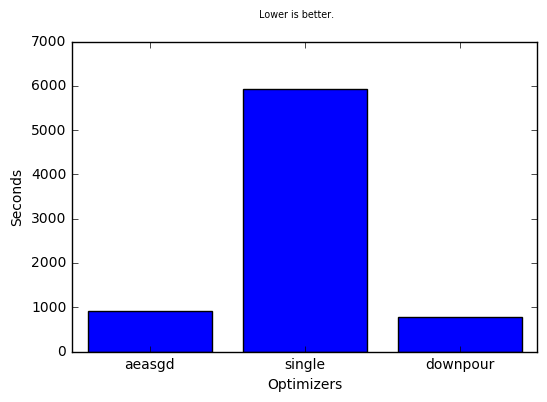

In [27]:
# Plot the time.
fig = plt.figure()
st = fig.suptitle("Lower is better.", fontsize="x-small")

plt.bar(range(len(time_spent)), time_spent.values(), align='center')
plt.xticks(range(len(time_spent)), time_spent.keys())
plt.xlabel("Optimizers")
plt.ylabel("Seconds")
plt.ylim([0, 7000])
plt.show()

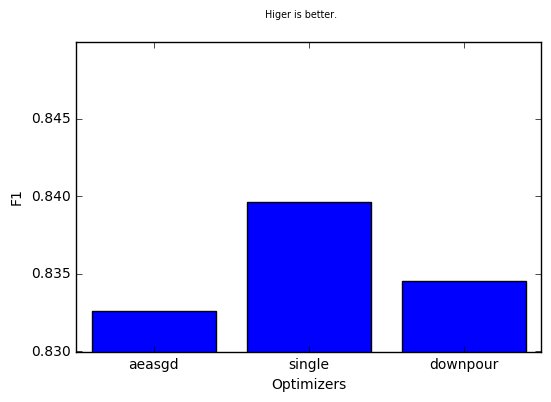

In [28]:
# Plot the statistical performanc of the optimizers.
fig = plt.figure()
st = fig.suptitle("Higer is better.", fontsize="x-small")

plt.bar(range(len(results)), results.values(), align='center')
plt.xticks(range(len(results)), results.keys())
plt.xlabel("Optimizers")
plt.ylabel("F1")
plt.ylim([0.83,0.85])
plt.show()